In [1]:
import numpy
import matplotlib
from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot
from matplotlib.pyplot import *
import os
import glob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs

from pylab import *
from numpy import *

import pandas as pd

from ipywidgets.widgets import interact, interactive, fixed
from ipywidgets import widgets
from scipy import fftpack
from IPython.display import display
from PIL import Image
import pims
import scipy.optimize as optimization
import pandas as pd
import pymongo
import gridfs
import mimetypes

In [2]:
from cine_mongodb import *

In [3]:
# connect to the database
conn=pymongo.MongoClient()
grid_fs = gridfs.GridFS(conn.microrheology)
grid_fs_collection=conn.microrheology.fs.files

In [4]:
video=grid_fs.get_last_version('400nm_100dil_water_01umpix_100fps_short.cin')
pims_video=Cine(video)
pims_video.info=video.info
pims_video.result_PT=pd.read_json(video.result_PT)

# Differential Dinamic Microscopy analysis

based on:

Cerbino, Roberto, and Veronique Trappe. "Differential dynamic microscopy: probing wave vector dependent dynamics with a microscope." Physical review letters 100.18 (2008): 188102.

In [5]:
def browse_images_FFT(video):
    
    frames=len(video)
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    
    def view_image(framenum,delta):
        figure(figsize=(12,8))
        
        im1=video[framenum].astype(np.float)
        im2=video[framenum+delta].astype(np.float)
        imdiff=im2-im1

        F1=fftpack.fft2(imdiff)
        F2 = fftpack.fftshift( F1 )
        psd2D = np.abs( F2 )**2
        psd1D = azimuthalAverage(psd2D)
        
        
        subplot(2,3,1)
        title('(a) image 1 $I(r,t)$, time: ' + str(framenum*interval) + ' s')
        imshow( im1)
        set_cmap('gray')
        axis('off')
        
        subplot(2,3,2)
        title('(b) image 2 $I(r,t+ \Delta t)$, time: ' + str((framenum+delta)*interval) + ' s')
        imshow( im2)
        set_cmap('gray')
        axis('off')
        
        subplot(2,3,3)
        title('(c) image2-image1, delta t:'+ str((delta)*interval) +
              ' s\n $I( q ,t+ \Delta t ) - I(q,t)$')
        imshow( imdiff)
        set_cmap('gray')
        axis('off')
        
        subplot(2,3,4)
        title('(d)FFT - $g(q,t)$ ')
        imshow( np.log10( psd2D ))
        subplot(2,3,5)
        plot( psd1D )
        yscale('log')
    
        xlabel('Spatial Frequency')
        ylabel('Power Spectrum')
        subplot(2,3,6)
        plot( psd1D )
        xscale('log')
        yscale('log')
        xlabel('Spatial Frequency')
        ylabel('Power Spectrum')
        show()
        
    w=interactive(view_image, framenum=(0,frames),delta=(1,frames-100))
    return w

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof


        
    w=interactive(view_plot, selectq=(1,len(iq2[1,:]-1)),deltat=(1,len(deltalistsec)-1))
    return w

def browse_images(video):
    frames=len(video)
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    def view_image(framenum):
        #figure(figsize=(6,6))
        toplot=video[framenum]
        title(str(' time: ' + str(framenum*interval) + ' s'))
        imshow(toplot)
        set_cmap('gray')
        axis('off')
        show()
        
        
    w=interactive(view_image, framenum=(0,frames-21))
    return w  

In [6]:
 browse_images_FFT(pims_video)

interactive(children=(IntSlider(value=150, description='framenum', max=300), IntSlider(value=100, description=…

In [7]:
progress_frame_pair=widgets.Text(description='current differential frame realization', value='')
progress_dt=widgets.Text(description='current dt', value='0')
progress_name=widgets.Text(description='Currently processed file ', value='')

def _calculate_iq_delta(video,delta,naverage=None):
    
    frames=len(video)
    progress_dt.value=str(delta)
    
    iq=[]
    
    if naverage is None:
        naverage=frames-delta
    
    framelist=range(0,frames-delta,int((frames-delta)/naverage))
    
    for frame in framelist:
        
        im1=video[frame].astype(np.float)
        im2=video[frame+delta].astype(np.float)
        imdiff=im2-im1

        F1=fftpack.fft2(imdiff)
        F2 = fftpack.fftshift( F1 )
        psd2D = np.abs( F2 )**2
        psd1D = azimuthalAverage(psd2D)
        
        iq.append(psd1D)
        
        progress_frame_pair.value=str(frame)
        
    return mean(iq,0)

def _calculate_iq_delta_multi(video,deltalist,naverage=None):

    frames=len(video)
    iq_matrix=[]
        
    for delta in deltalist:
        iq_matrix.append(_calculate_iq_delta(video,delta,naverage))
    
    return array(iq_matrix)

def calculate_DDM(video,naverage=None,numdt=None):
    
    if numdt is None:
        numdt=20
    
    if naverage is None:
        naverage=10
    
    progress_name.value=video.info['filename']
    frames=len(video)
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    frame_len=video.frame_shape[0]  #assuming is a square 
    filename=video.info['filename']

    deltalist=unique(logspace(0, log10(frames-int(frames/2)), num=numdt, endpoint=True, base=10.0, dtype=int))
    
    deltalistsec=transpose(array(deltalist)*interval)

    iq=_calculate_iq_delta_multi(video,deltalist,naverage)
    
    xax=array(range(iq.shape[1]))*2*pi/(muperpix*frame_len)
    
    result=pd.DataFrame(iq,index=deltalistsec, columns=xax)
    
    video.result_FFT=result    
    return video

In [8]:
display(progress_frame_pair)
display(progress_dt)
display(progress_name)
pims_video=calculate_DDM(pims_video,naverage=10,numdt=20)

Text(value='', description='current differential frame realization')

Text(value='0', description='current dt')

Text(value='', description='Currently processed file ')

In [9]:
#saving the DDM result back to the database object

id_obj=video._id
video_obj=grid_fs_collection.find_one(id_obj)
json_res_fft=pims_video.result_FFT.to_json(orient='split')
video_obj['result_FFT']=json_res_fft
grid_fs_collection.update_one({'_id':id_obj}, {"$set": video_obj}, upsert=False)

In [10]:
#retrieving video from database and reconstructing pims_video
video=grid_fs.get_last_version('400nm_100dil_water_01umpix_100fps_short.cin')
pims_video=Cine(video)
pims_video.info=video.info
pims_video.result_PT=pd.read_json(video.result_PT)
pims_video.result_FFT=pd.read_json(video.result_FFT,orient='split')

In [11]:
from lmfit import  Model
from IPython.display import clear_output
import lmfit

def DDM_func(x, off, amp, tau):
    return (off + amp * (1 - exp(-x/tau)))

DDMmod = Model(DDM_func)


def calculate_viscosity(video,radius=1,qmin=None,qmax=None):
    
    if qmin is None:
        qmin=1
        
        
    frames=len(video)
    frame_len=shape(video[0])[0]
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    
    result=video.result_FFT
    xax=result.columns
    result=result[sort(list(xax))]
    deltalistsec=array(result.index)
    iq2=result.values
    xax=result.columns
    
    if qmax is None:
        qmax=len(xax)
    
    tau=[]
    xax=[]
    
    for i in range(qmin,qmax):
        
        try:
            result = DDMmod.fit(iq2[1:,i], x=deltalistsec[1:], amp=max(iq2[1:,i])-min(iq2[1:,i]),
                                off=min(iq2[1:,i]),
                                tau=mean(deltalistsec[1:]))
        
            tau.append(result.params['tau'].value)
            xax.append(i*2*pi/(muperpix*frame_len))
        except:
            pass
            
    PL_model=lmfit.models.PowerLawModel()
    pars = PL_model.guess(array(tau), x=xax)
    out  = PL_model.fit(array(tau), pars, x=xax)
    amplitude=out.params['amplitude'].value
    
    plot(xax,transpose(array(tau)),'o')
    plot(xax,out.best_fit)
    #xscale('log')
    #yscale('log')
    xlabel('q [um-1]')
    ylabel('tau [s]')
    
    Dm=1/amplitude
    viscosity=1.3806488E-23 * (273+video.info['temperature']) / (6*3.14*Dm*radius*1e-18)
    print(viscosity)
    
    return viscosity


def explore_iq_dt(video):
    
    frames=len(video)
    frame_len=shape(video[0])[0]
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    result=video.result_FFT
    xax=result.columns
    result=result[sort(list(xax))]
    deltalistsec=result.index
    iq2=result.values
    xax=result.columns
    
    def view_plot(selectq,deltat):
        figure(figsize=(15,3))
        
        gamma=[]
        aq=[]
        bq=[]
        
        subplot(1,3,1)
        plot(xax,iq2[deltat,:],'o')
        yscale('log')
        xscale('log')
        ylabel('I(q) [a.u.]')
        xlabel('q [um-1]')
        axvline(xax[selectq], color='k', linestyle='--')
        title(r'I(q) fixed $\Delta t$')
        
        
        subplot(1,3,2)
        plot(deltalistsec,iq2[:,selectq],'o')
        xscale('log')
        yscale('log')
        ylabel('g(q,dt) [a.u]')
        xlabel('Delta t [s]')

        try:
            result = DDMmod.fit(iq2[1:,selectq], x=deltalistsec[1:], amp=max(iq2[1:,selectq])-min(iq2[1:,selectq]),
                                off=min(iq2[1:,selectq]),
                                tau=mean(deltalistsec[1:]));
            #clear_output()
            tau=result.params['tau'].value
            off=result.params['off'].value
            amp=result.params['amp'].value

            plot(deltalistsec[1:], result.best_fit, 'r-')
            axvline(deltat*interval, color='k', linestyle='--')

            subplot(1,3,3)
            plot(deltalistsec,-((iq2[:,selectq]-(off+amp))/amp),'o')
            plot(deltalistsec,exp(-deltalistsec/tau))
            axvline(deltat*interval, color='k', linestyle='--')
            xscale('log')
            ylabel('f(q,dt) [a.u.]')
            xlabel('Delta t')
        except:
            pass
            
        
        
    w=interactive(view_plot, selectq=(1,len(iq2[1,:]-1)),deltat=(1,len(deltalistsec)-1))
    return w

In [12]:
explore_iq_dt(pims_video)

interactive(children=(IntSlider(value=180, description='selectq', max=360, min=1), IntSlider(value=8, descript…

$$g(q,\tau) = A(q) [1-f(q,\tau)] +B(q)$$

$$f(q,\tau) = e^{-Dq^2 \tau}$$

$$ \tau=\frac{D}{q^2}$$

Text(0,0.5,'q')

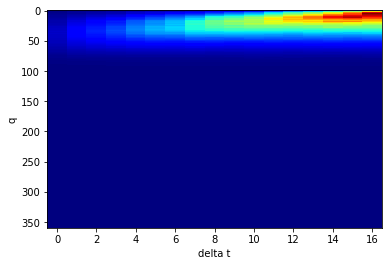

In [13]:
imshow(pims_video.result_FFT.transpose(),cmap='jet',aspect='auto')
xlabel("delta t")
ylabel('q')

0.000657345438791


0.00065734543879134044

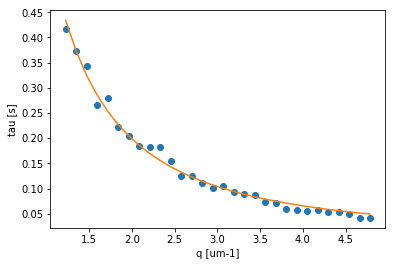

In [14]:
calculate_viscosity(pims_video,radius=0.2,qmin=10,qmax=40)